CSVs retrieved from: https://data.ontario.ca/dataset/long-term-care-home-covid-19-data

In [37]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import numpy as np

<ipython-input-37-6a8003fe56c4>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Import, filter for dates up to Aug 1 and sort

In [2]:
# active = pd.read_csv("https://data.ontario.ca/datastore/dump/4b64488a-0523-4ebb-811a-fac2f07e6d59?bom=True")
# inactive = pd.read_csv("https://data.ontario.ca/dataset/42df36df-04a0-43a9-8ad4-fac5e0e22244/resource/0cf2f01e-d4e1-48ed-8027-2133d059ec8b/download/resolvedltc.csv")

# Import active and resolved csv, filter for dates up to Aug 1 and sort by LTC home then date
active = pd.read_csv('activeltcoutbreak_oct8.csv')
active['Report_Data_Extracted'] = pd.to_datetime(active['ï»¿Report_Data_Extracted'])
active.drop('ï»¿Report_Data_Extracted', axis = 1, inplace = True)
active = active[active.Report_Data_Extracted < '2020-08-01']
# active['LTC_Home'] = active['LTC_Home'].str.lower()
active.sort_values(['LTC_Home', 'Report_Data_Extracted'], inplace=True)
active.info()

resolved = pd.read_csv('resolvedltc_oct8.csv')
resolved['Report_Data_Extracted'] = pd.to_datetime(resolved['ï»¿Report_Data_Extracted'])
resolved.drop('ï»¿Report_Data_Extracted', axis = 1, inplace = True)
resolved = resolved[resolved.Report_Data_Extracted < '2020-08-01']
# resolved['LTC_Home'] = resolved['LTC_Home'].str.lower()
resolved.sort_values(['LTC_Home', 'Report_Data_Extracted'], inplace=True)
resolved.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8933 entries, 7738 to 8917
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   LTC_Home                   8933 non-null   object        
 1   LTC_City                   0 non-null      float64       
 2   Beds                       8932 non-null   float64       
 3   Total_LTC_Resident_Cases   8933 non-null   object        
 4   Total_LTC_Resident_Deaths  8933 non-null   object        
 5   Total_LTC_HCW_Cases        8932 non-null   object        
 6   Report_Data_Extracted      8933 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 558.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19532 entries, 11687 to 18995
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   LTC_Home

## Clean

In [3]:
# Drop LTC_City as this column has no data
active.drop('LTC_City', axis=1, inplace=True)

In [4]:
# One row (229) in active with missing Total_LTC_HCW_Cases value, for meadow park (london)
# active[active['Total_LTC_HCW_Cases'].isnull()]

# As the Total_LTC_HCW_Cases is 0 the day before and the day after, will impute 0
active.at[229, 'Total_LTC_HCW_Cases'] = 0

# active[active['LTC_Home'] == 'meadow park (london)'] 

In [5]:
# One row(2920) in active with missing Beds value, for north park nursing home
# active[active['Beds'].isnull()]


# As Beds is 75 in all the other rows for this nursing home, will impute 75
active.at[2920, 'Beds'] = 75
# active[active['LTC_Home'] == 'north park nursing home'] 

### Replace <5 values with 1

In [6]:
# Replace <5 values with 1
active = active.replace(['<5'], 1)
resolved = resolved.replace(['<5'], 1)

In [7]:
# Convert cases and deaths to integer datatypes
ls = ['Total_LTC_Resident_Cases', 'Total_LTC_Resident_Deaths', 'Total_LTC_HCW_Cases']
for each in ls:
    active[each] = pd.to_numeric(active[each])
    active[each] = active[each].astype(int)

resolved['Total_LTC_Resident_Deaths'] = pd.to_numeric(resolved['Total_LTC_Resident_Deaths']).astype(int)
resolved['Beds'] = pd.to_numeric(resolved['Beds']).astype(int)

active.info()
resolved.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8933 entries, 7738 to 8917
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   LTC_Home                   8933 non-null   object        
 1   Beds                       8933 non-null   float64       
 2   Total_LTC_Resident_Cases   8933 non-null   int64         
 3   Total_LTC_Resident_Deaths  8933 non-null   int64         
 4   Total_LTC_HCW_Cases        8933 non-null   int64         
 5   Report_Data_Extracted      8933 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 808.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19532 entries, 11687 to 18995
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   LTC_Home                   19532 non-null  object        
 1 

In [ ]:
# # Inspect data for Almonte Country Haven
# # The number of deaths went from 30 to 29 on June 16?
# almonte = active[active.LTC_Home.str.contains("almonte", na=False)]
# almonte['Total_LTC_Resident_Deaths'].is_monotonic

# afton = active[active.LTC_Home.str.contains("afton", na=False)]
# afton['Total_LTC_Resident_Deaths'].is_monotonic

## Check if active case and death numbers are cumulative

In [8]:
# Check to see if Total_LTC_Resident_Deaths is monotonically increasing for each home
ls = list(set(active['LTC_Home']))
home_names = []
monotonic = []
for each in ls:
    home_names.append(each)
    home = active.loc[active['LTC_Home'] == each]
    monotonic.append(home['Total_LTC_Resident_Deaths'].is_monotonic)
    
monostatus = pd.DataFrame({'LTC_Home': home_names,
                           'monotonic': monotonic})

In [9]:
# 17 homes do not have monotonically increasing values for deaths
monostatus['monotonic'].value_counts()

not_monotonic = monostatus.loc[monostatus['monotonic']==False]
not_monotonic['LTC_Home']

4      Nisbet Lodge                                  
14     Montfort                                      
28     Country Village Homes - Woodslee              
36     Isabel and Arthur Meighen Manor               
37     Hellenic Home - Scarborough                   
109    Villa Leonardo Gambin                         
114    River Glen Haven Nursing Home                 
120    Garden Court Nursing Home                     
129    Almonte Country Haven                         
138    Garden Terrace                                
148    Orchard Villa                                 
153    Chartwell Ballycliffe Long Term Care Residence
233    Parkview Manor Health Care Centre             
240    Mackenzie Health Long Term Care Facility      
251    Extendicare Bayview                           
287    Tendercare Living Centre                      
300    The Village at University Gates               
Name: LTC_Home, dtype: object

In [ ]:
# # Check to see if Total_LTC_Resident_Cases is monotonically increasing for each home
# ls = list(set(active['LTC_Home']))
# home_names = []
# monotonic = []
# for each in ls:
#     home_names.append(each)
#     home = active.loc[active['LTC_Home'] == each]
#     monotonic.append(home['Total_LTC_Resident_Cases'].is_monotonic)
    
# monostatus = pd.DataFrame({'LTC_Home': home_names,
#                            'monotonic': monotonic})

In [ ]:
# # 131 homes do not have monotonically increasing values for HCW_Cases
# monostatus['monotonic'].value_counts()

# # not_monotonic = monostatus.loc[monostatus['monotonic']==False]
# # len(not_monotonic['LTC_Home'])

In [ ]:
# # Check to see if Total_LTC_HCW_Cases is monotonically increasing for each home
# ls = list(set(active['LTC_Home']))
# home_names = []
# monotonic = []
# for each in ls:
#     home_names.append(each)
#     home = active.loc[active['LTC_Home'] == each]
#     monotonic.append(home['Total_LTC_HCW_Cases'].is_monotonic)
    
# monostatus = pd.DataFrame({'LTC_Home': home_names,
#                            'monotonic': monotonic})

In [ ]:
# # 108 homes do not have monotonically increasing values for HCW_Cases
# monostatus['monotonic'].value_counts()

# # not_monotonic = monostatus.loc[monostatus['monotonic']==False]
# # len(not_monotonic['LTC_Home'])

## Inspect trend where deaths not monotonically increasing

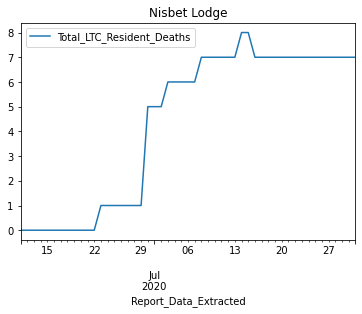

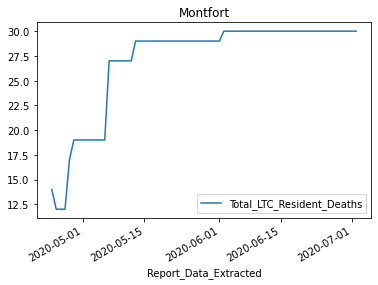

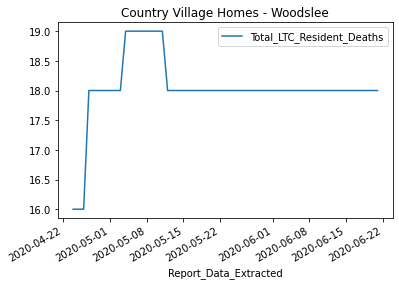

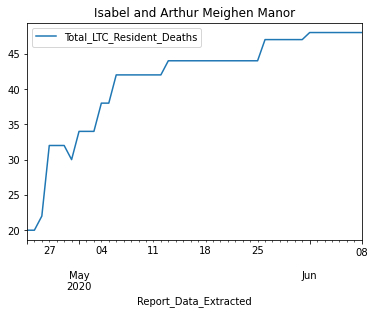

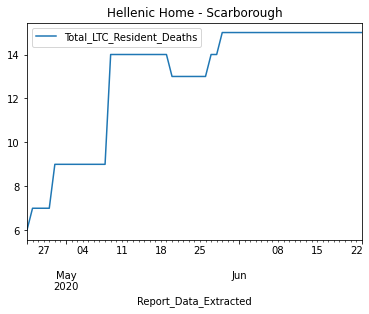

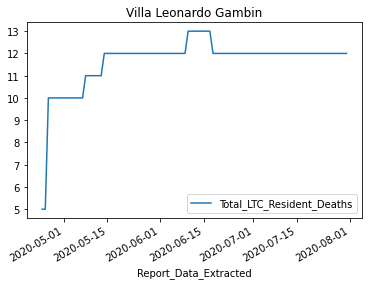

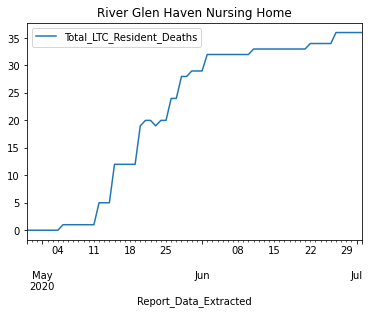

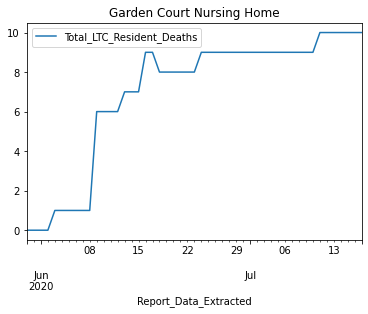

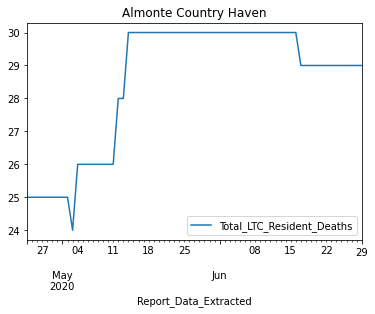

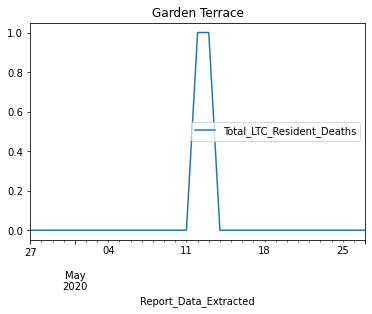

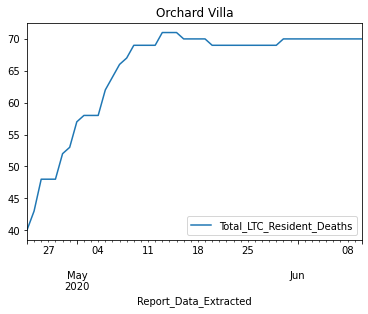

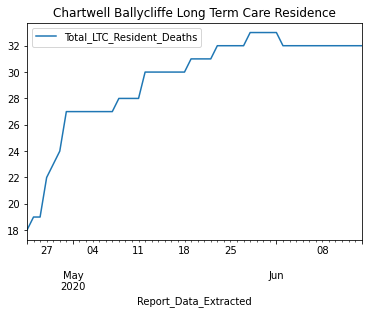

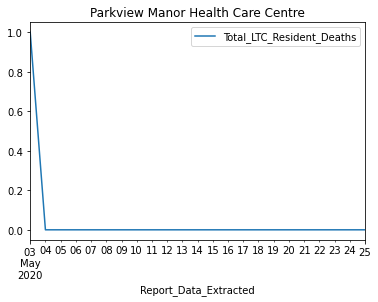

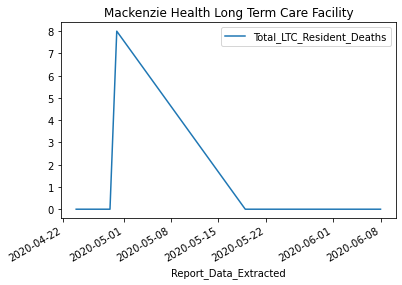

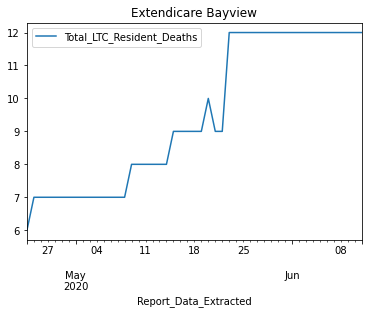

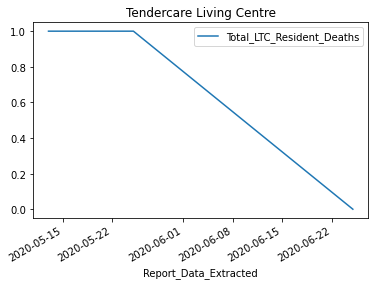

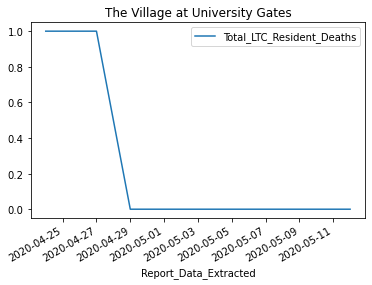

In [10]:
# Inspect residents deaths over time for homes where deaths are not monotonically increasing
# Generally when values decrease it is only by one, except for 'Mackenzie Health Long Term Care Facility' and perhaps 'Orchard Villa'
ls = not_monotonic['LTC_Home']
for each in ls:
    home = active.loc[active['LTC_Home'] == each]
    home.plot('Report_Data_Extracted', 'Total_LTC_Resident_Deaths', title=each)
                      

In [ ]:
# # Look in depth at the data for the homes with large changes in death values
# # Mackenzie Health Long Term Care Facility
# active.loc[active['LTC_Home'] == 'Mackenzie Health Long Term Care Facility'] # cases/deaths reported on April 30 (end of first outbreak)
# resolved.loc[resolved['LTC_Home'] == 'Mackenzie Health Long Term Care Facility'] # appears on resolved list starting Jun 9

# # Orchard Villa 
# active.loc[active['LTC_Home'] == 'Orchard Villa'] # max 71, final 70 deaths
# # resolved.loc[resolved['LTC_Home'] == 'Orchard Villa'] # appears on resolved list starting Jun 11 as 70


In [11]:
# Get max values for each home in active
active_max = active.groupby('LTC_Home').max()
active_max.drop('Report_Data_Extracted', axis=1, inplace=True)
active_max.head()

# Rename columns
active_max.rename(columns={'Total_LTC_Resident_Cases':'max_resident_cases',
                           'Total_LTC_Resident_Deaths': 'cumulative_resident_deaths',
                           'Total_LTC_HCW_Cases': 'max_hcw_cases',
                           'Beds': 'max_beds'}, inplace=True)

active_max = active_max.reset_index()
active_max.head()
# active_max.index

,LTC_Home,max_beds,max_resident_cases,cumulative_resident_deaths,max_hcw_cases
0,Afton Park Place Long Term Care Community,128.0,0,0,1
1,"Albright Gardens Homes, Incorporated",231.0,1,0,1
2,Alexander Place,128.0,1,0,0
3,Almonte Country Haven,82.0,45,30,23
4,Altamont Care Community,159.0,125,53,62


## Extract first date of outbreak, first date of max cases, first date of max HCW cases (active)

In [13]:
# First date of outbreak
first_outbreak = active[active['LTC_Home'].shift(1) != active['LTC_Home']]
# first_outbreak.info()
# first_outbreak.head()

ls = ['Beds', 'Total_LTC_Resident_Cases', 'Total_LTC_Resident_Deaths', 'Total_LTC_HCW_Cases']
first_outbreak.drop(ls, axis=1, inplace=True)

# Rename columns
first_outbreak.rename(columns={'Report_Data_Extracted':'date_first_outbreak'}, inplace=True)

first_outbreak.info()
first_outbreak.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 7738 to 36
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LTC_Home             317 non-null    object        
 1   date_first_outbreak  317 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 7.4+ KB


/home/nganhien/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/nganhien/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,LTC_Home,date_first_outbreak
7738,Afton Park Place Long Term Care Community,2020-06-22
0,"Albright Gardens Homes, Incorporated",2020-04-24
4300,Alexander Place,2020-05-19
1,Almonte Country Haven,2020-04-24
2,Altamont Care Community,2020-04-24


In [14]:
# First date max cases
names = active_max['LTC_Home']
max_cases = active_max['max_resident_cases']
dict_max_cases = dict(zip(names, max_cases))

max_cases_rows = active[active['LTC_Home'].map(dict_max_cases) == active['Total_LTC_Resident_Cases']]
first_max_cases = max_cases_rows[max_cases_rows['LTC_Home'].shift(1) != max_cases_rows['LTC_Home']]
ls = ['Beds', 'Total_LTC_Resident_Cases', 'Total_LTC_Resident_Deaths', 'Total_LTC_HCW_Cases']
first_max_cases.drop(ls, axis=1, inplace=True)
first_max_cases.rename(columns={'Report_Data_Extracted':'date_max_cases'}, inplace=True)
first_max_cases.info()

# First date max hcw cases
names = active_max['LTC_Home']
max_cases = active_max['max_hcw_cases']
dict_max_cases = dict(zip(names, max_cases))

max_cases_rows = active[active['LTC_Home'].map(dict_max_cases) == active['Total_LTC_HCW_Cases']]
first_max_HCWcases = max_cases_rows[max_cases_rows['LTC_Home'].shift(1) != max_cases_rows['LTC_Home']]
ls = ['Beds', 'Total_LTC_Resident_Cases', 'Total_LTC_Resident_Deaths', 'Total_LTC_HCW_Cases']
first_max_HCWcases.drop(ls, axis=1, inplace=True)
first_max_HCWcases.rename(columns={'Report_Data_Extracted':'date_max_HCWcases'}, inplace=True)
first_max_HCWcases.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 7738 to 3776
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   LTC_Home        317 non-null    object        
 1   date_max_cases  317 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 7.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 7738 to 4697
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   LTC_Home           317 non-null    object        
 1   date_max_HCWcases  317 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 7.4+ KB


/home/nganhien/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/nganhien/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Merge data (from active list)

In [15]:
from functools import reduce
active_data = reduce(lambda x,y: pd.merge(x,y, on='LTC_Home', how='outer'), [active_max, first_outbreak, first_max_cases, first_max_HCWcases])
active_data.info()
active_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317 entries, 0 to 316
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   LTC_Home                    317 non-null    object        
 1   max_beds                    317 non-null    float64       
 2   max_resident_cases          317 non-null    int64         
 3   cumulative_resident_deaths  317 non-null    int64         
 4   max_hcw_cases               317 non-null    int64         
 5   date_first_outbreak         317 non-null    datetime64[ns]
 6   date_max_cases              317 non-null    datetime64[ns]
 7   date_max_HCWcases           317 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 22.3+ KB


,LTC_Home,max_beds,max_resident_cases,cumulative_resident_deaths,max_hcw_cases,date_first_outbreak,date_max_cases,date_max_HCWcases
0,Afton Park Place Long Term Care Community,128.0,0,0,1,2020-06-22,2020-06-22,2020-06-22
1,"Albright Gardens Homes, Incorporated",231.0,1,0,1,2020-04-24,2020-04-24,2020-04-24
2,Alexander Place,128.0,1,0,0,2020-05-19,2020-05-19,2020-05-19
3,Almonte Country Haven,82.0,45,30,23,2020-04-24,2020-05-03,2020-05-01
4,Altamont Care Community,159.0,125,53,62,2020-04-24,2020-04-24,2020-05-14


## Clean the Resolved data

In [16]:
# Check to see if Total_LTC_Resident_Deaths is monotonically increasing for each home
ls = list(set(resolved['LTC_Home']))
home_names = []
monotonic = []
for each in ls:
    home_names.append(each)
    home = resolved.loc[resolved['LTC_Home'] == each]
    monotonic.append(home['Total_LTC_Resident_Deaths'].is_monotonic)
    
monostatus = pd.DataFrame({'LTC_Home': home_names,
                           'monotonic': monotonic})

In [17]:
# 4 homes do not have monotonically increasing values for deaths
monostatus['monotonic'].value_counts()

not_monotonic = monostatus.loc[monostatus['monotonic']==False]
not_monotonic['LTC_Home']

66     Wellesley Central Place             
293    Tendercare Living Centre            
307    The Village at University Gates     
311    Lanark Heights Long Term Care Centre
Name: LTC_Home, dtype: object

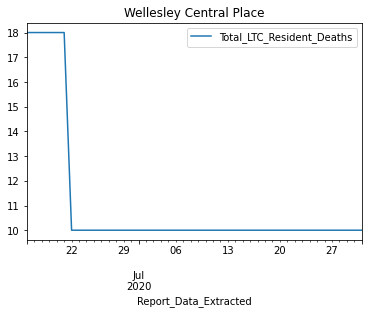

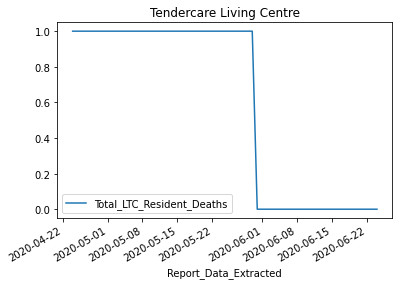

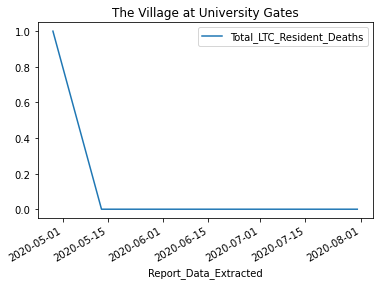

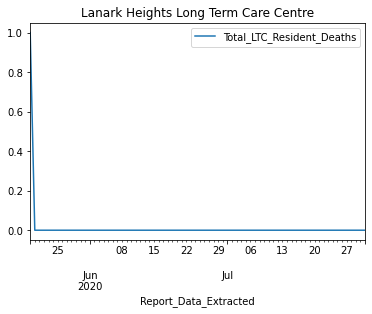

In [18]:
# 3/4 homes where values did not increase dropped from 1 to 0
# wellesley central place went from 18 to 10
ls = not_monotonic['LTC_Home']
for each in ls:
    home = resolved.loc[resolved['LTC_Home'] == each]
    home.plot('Report_Data_Extracted', 'Total_LTC_Resident_Deaths', title=each)

In [20]:
# Inspect Wellesley Central Place
# active.loc[active['LTC_Home'] == 'Wellesley Central Place'] # max deaths on active list was 18, 4/24 to 6/15
resolved.loc[resolved['LTC_Home'] == 'Wellesley Central Place'] # deaths dropped from 18 to 10 6/21 to 6/22

,LTC_Home,City,Beds,Total_LTC_Resident_Deaths,Report_Data_Extracted
6753,Wellesley Central Place,Toronto,150,18,2020-06-16
6995,Wellesley Central Place,Toronto,150,18,2020-06-17
7239,Wellesley Central Place,Toronto,150,18,2020-06-18
7485,Wellesley Central Place,Toronto,150,18,2020-06-19
7731,Wellesley Central Place,Toronto,150,18,2020-06-20
7978,Wellesley Central Place,Toronto,150,18,2020-06-21
8230,Wellesley Central Place,Toronto,150,10,2020-06-22
8484,Wellesley Central Place,Toronto,150,10,2020-06-23
8742,Wellesley Central Place,Toronto,150,10,2020-06-24
9000,Wellesley Central Place,Toronto,150,10,2020-06-25


In [21]:
# For each home, keep max deaths
resolved_max = resolved.groupby('LTC_Home').max()
# resolved_max.head()
ls = ['City', 'Report_Data_Extracted']
resolved_max.drop(ls, axis=1, inplace=True)

# Rename columns
resolved_max.rename(columns={'Total_LTC_Resident_Deaths': 'cumulative_resident_deaths_res',
                             'Beds': 'max_beds_res'}, inplace=True)

resolved_max = resolved_max.reset_index()
resolved_max.info()
# resolved_max.head()

# For each home, keep min date
resolved_min = resolved.groupby('LTC_Home').min()
ls = ['City', 'Beds', 'Total_LTC_Resident_Deaths']
resolved_min.drop(ls, axis=1, inplace=True)

# Rename columns
resolved_min.rename(columns={'Report_Data_Extracted':'date_first_resolved'}, inplace=True)

resolved_min = resolved_min.reset_index()
resolved_min.info()
# resolved_min.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   LTC_Home                        324 non-null    object
 1   max_beds_res                    324 non-null    int64 
 2   cumulative_resident_deaths_res  324 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LTC_Home             324 non-null    object        
 1   date_first_resolved  324 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 5.2+ KB


## Merge resolved datasets

In [22]:
from functools import reduce
resolved_data = reduce(lambda x,y: pd.merge(x,y, on='LTC_Home', how='outer'), [resolved_max, resolved_min])
resolved_data.info()
resolved_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LTC_Home                        324 non-null    object        
 1   max_beds_res                    324 non-null    int64         
 2   cumulative_resident_deaths_res  324 non-null    int64         
 3   date_first_resolved             324 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 12.7+ KB


,LTC_Home,max_beds_res,cumulative_resident_deaths_res,date_first_resolved
0,Afton Park Place Long Term Care Community,128,0,2020-07-06
1,"Albright Gardens Homes, Incorporated",231,0,2020-04-27
2,Alexander Place,128,0,2020-06-02
3,Allendale,200,0,2020-04-24
4,Almonte Country Haven,82,29,2020-06-30


# Merge the cleaned active and resolved datasets

In [23]:
# Function to look for matches
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [24]:
a = active_data['LTC_Home'].unique() # .unique() allows the function to work
b = resolved_data['LTC_Home'].unique()
diff = returnNotMatches(a, b)

# 11 homes in active that is not in resolved, ?homes with active outbreak on July 31 
a = diff[0]
len(a)

# 18 homes in resolved that is not in active, ?homes with resolved outbreaks before Apr 24
b = diff[1]
len(b)


18

In [47]:
outbreaks = pd.merge(left=active_data, right=resolved_data, how='outer', 
                  left_on='LTC_Home', right_on='LTC_Home')
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LTC_Home                        335 non-null    object        
 1   max_beds                        317 non-null    float64       
 2   max_resident_cases              317 non-null    float64       
 3   cumulative_resident_deaths      317 non-null    float64       
 4   max_hcw_cases                   317 non-null    float64       
 5   date_first_outbreak             317 non-null    datetime64[ns]
 6   date_max_cases                  317 non-null    datetime64[ns]
 7   date_max_HCWcases               317 non-null    datetime64[ns]
 8   max_beds_res                    324 non-null    float64       
 9   cumulative_resident_deaths_res  324 non-null    float64       
 10  date_first_resolved             324 non-null    datetime64[ns]
dtypes: dat

In [48]:
# Compare beds numbers between active and resolved, 29 discrepancies
a = pd.Series.eq(outbreaks['max_beds'], outbreaks['max_beds_res'])
a.value_counts()

# Discrepancies are due to NAN values, otherwise the numbers agree
diff = outbreaks['max_beds'] - outbreaks['max_beds_res']
diff
diff.value_counts()

0.0    306
dtype: int64

In [49]:
# Merge beds columns
outbreaks['beds'] = np.where(outbreaks['max_beds'].isnull(), outbreaks['max_beds_res'], outbreaks['max_beds'])
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LTC_Home                        335 non-null    object        
 1   max_beds                        317 non-null    float64       
 2   max_resident_cases              317 non-null    float64       
 3   cumulative_resident_deaths      317 non-null    float64       
 4   max_hcw_cases                   317 non-null    float64       
 5   date_first_outbreak             317 non-null    datetime64[ns]
 6   date_max_cases                  317 non-null    datetime64[ns]
 7   date_max_HCWcases               317 non-null    datetime64[ns]
 8   max_beds_res                    324 non-null    float64       
 9   cumulative_resident_deaths_res  324 non-null    float64       
 10  date_first_resolved             324 non-null    datetime64[ns]
 11  beds  

In [50]:
# Compare death numbers between active and resolved, 49 discrepancies
a = pd.Series.eq(outbreaks['cumulative_resident_deaths'], outbreaks['cumulative_resident_deaths_res'])
a.value_counts()

# Differences and counts are below
#  0.0    286
#  1.0    10 
# -1.0    6  
#  2.0    1  
# -2.0    1  
#  8.0    1  
# -3.0    1

# 4 homes where there is a >1 difference between death counts in active vs resolved
outbreaks['diff_deaths'] = abs(outbreaks['cumulative_resident_deaths'] - outbreaks['cumulative_resident_deaths_res'])
outbreaks[outbreaks['diff_deaths'] > 1]
# diff
# diff.value_counts()



,LTC_Home,max_beds,max_resident_cases,cumulative_resident_deaths,max_hcw_cases,date_first_outbreak,date_max_cases,date_max_HCWcases,max_beds_res,cumulative_resident_deaths_res,date_first_resolved,beds,diff_deaths
136,Hawthorne Place Care Centre,269.0,96.0,48.0,105.0,2020-04-24,2020-05-20,2020-05-20,269.0,51.0,2020-06-19,269.0,3.0
167,Mackenzie Health Long Term Care Facility,168.0,47.0,8.0,19.0,2020-04-24,2020-04-30,2020-04-30,168.0,0.0,2020-06-09,168.0,8.0
173,Manoir Marochel,64.0,29.0,7.0,15.0,2020-04-24,2020-04-30,2020-04-30,64.0,9.0,2020-05-28,64.0,2.0
244,Stoneridge Manor,60.0,52.0,8.0,13.0,2020-04-24,2020-05-07,2020-04-24,60.0,6.0,2020-06-17,60.0,2.0


In [52]:
# Where deaths is NaN, replace with 0
outbreaks['cumulative_resident_deaths'].fillna(0, inplace = True)
outbreaks['cumulative_resident_deaths_res'].fillna(0, inplace = True)

# Keep the higher value for deaths
outbreaks['cum_resident_deaths'] = np.where(outbreaks['cumulative_resident_deaths'] >= outbreaks['cumulative_resident_deaths_res'],
                                            outbreaks['cumulative_resident_deaths'], outbreaks['cumulative_resident_deaths_res'])

outbreaks.info()
outbreaks.loc[outbreaks['LTC_Home']=='Mackenzie Health Long Term Care Facility']



<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   LTC_Home                        335 non-null    object        
 1   max_beds                        317 non-null    float64       
 2   max_resident_cases              317 non-null    float64       
 3   cumulative_resident_deaths      335 non-null    float64       
 4   max_hcw_cases                   317 non-null    float64       
 5   date_first_outbreak             317 non-null    datetime64[ns]
 6   date_max_cases                  317 non-null    datetime64[ns]
 7   date_max_HCWcases               317 non-null    datetime64[ns]
 8   max_beds_res                    324 non-null    float64       
 9   cumulative_resident_deaths_res  335 non-null    float64       
 10  date_first_resolved             324 non-null    datetime64[ns]
 11  beds  

,LTC_Home,max_beds,max_resident_cases,cumulative_resident_deaths,max_hcw_cases,date_first_outbreak,date_max_cases,date_max_HCWcases,max_beds_res,cumulative_resident_deaths_res,date_first_resolved,beds,diff_deaths,cum_resident_deaths
167,Mackenzie Health Long Term Care Facility,168.0,47.0,8.0,19.0,2020-04-24,2020-04-30,2020-04-30,168.0,0.0,2020-06-09,168.0,8.0,8.0


In [53]:
# Clean up columns
ls = ['cumulative_resident_deaths', 'cumulative_resident_deaths_res', 'max_beds_res', 'diff_deaths', 'max_beds']
outbreaks.drop(ls, axis=1, inplace=True)
cols = list(outbreaks.columns.values)
outbreaks = outbreaks[['LTC_Home',
                       'beds',
                       'cum_resident_deaths',
                       'max_resident_cases',
                       'max_hcw_cases',
                       'date_first_outbreak',
                       'date_max_cases',
                       'date_max_HCWcases',
                       'date_first_resolved']]
outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LTC_Home             335 non-null    object        
 1   beds                 335 non-null    float64       
 2   cum_resident_deaths  335 non-null    float64       
 3   max_resident_cases   317 non-null    float64       
 4   max_hcw_cases        317 non-null    float64       
 5   date_first_outbreak  317 non-null    datetime64[ns]
 6   date_max_cases       317 non-null    datetime64[ns]
 7   date_max_HCWcases    317 non-null    datetime64[ns]
 8   date_first_resolved  324 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(4), object(1)
memory usage: 26.2+ KB


In [54]:
# Export the outbreak data
outbreaks.to_csv('../data_output/ltc_outbreaks0731.csv')

## Code for keeping only data published on July 31

In [ ]:
# # Dataset with only values ON July 31
# active731 = active.loc[active['Report_Data_Extracted'] == '2020-07-31']
# resolved731 = resolved.loc[resolved['Report_Data_Extracted'] == '2020-07-31']

# active731.info()
# resolved731.info()

In [ ]:
# # Number of homes in the active list that are also in the resolved list, None
# # Would expect that there would be many homes on the resolved list that is not on the active list on July 31
# active731['LTC_Home'].isin(resolved731['LTC_Home']).value_counts()


In [ ]:
# outbreaks = pd.concat([active731, resolved731]) 
# outbreaks = outbreaks[['LTC_Home', 'Beds']] 

# outbreaks.info()
# outbreaks.head()

In [ ]:
# # Export the outbreak data
# outbreaks.to_csv('../data_output/ltc_outbreaks0731.csv')

## KT's code 

In [ ]:
# keep_indices = inactive.LTC_Home.drop_duplicates(keep='first').index.to_list()
# inactiveFiltered = inactive.iloc[keep_indices]

# keep_indices2 = active.LTC_Home.drop_duplicates(keep='first').index.to_list()
# activeFiltered = active.iloc[keep_indices2]

Merge - dropping duplicates where LTCs are in both active and inactive lists, keeping the active home.

First, check that no homes reported more than one outbreak.

**NL**
- Given that we had dropped duplicate `LTC_Home` above from the `active` and `inactive` dfs, would not expect to capture info on homes that reported more than one outbreak

In [ ]:
# # Inspect
# # There are 342 homes on the active list and 346 homes on the inactive list
# # Suggests there are homes where outbreaks recorded as resolved were never recorded as having an active outbreak
# inactiveFiltered.info()
# inactiveFiltered.head(20)
# inactiveFiltered.nunique()
# activeFiltered.info()
# activeFiltered.head(20)
# activeFiltered.nunique()

In [ ]:
# outbreaks = pd.concat([inactiveFiltered, activeFiltered])
# outbreaks.info()
# outbreaks.head()

In [ ]:
# grouped = outbreaks.groupby(["LTC_Home","outbreak_status"]).count()
# grouped.info()
# grouped.head()

In [ ]:
# grouped.loc[grouped["Report_Data_Extracted"] > 1]

In [ ]:
# # For homes that appear in both active and inactive, keep the most recent classification
# # For inactive homes you have the first date when an outbreak was classified as resolved
# # For acitve homes you have the first date when an outbreak was declared
# outbreaks.drop_duplicates(subset='LTC_Home', keep="last", inplace = True)
# outbreaks.info()

Filter for those reported before August 1, 2020:

**NL**
- If we filter like this do we fail to capture homes that reported on outbreak before Aug 1, but then where the outbreak was reported as being resolved after Aug 1

In [ ]:
# outbreaksAug1 = outbreaks.loc[outbreaks['Report_Data_Extracted'] < "2020-08-01"]

Import LTC data and merged with outbreaks:

In [ ]:
# ltc = pd.read_csv("../merge_LTC_database/webscrape_LTC_general_database.csv")

In [ ]:
# outbreaksAug1["name"] = outbreaksAug1.LTC_Home.str.upper()
# complete = pd.merge(ltc, outbreaksAug1, on = "name")

In [ ]:
# print("Number of homes in outbreak DF missing after merge: ", len(set(outbreaksAug1.name.unique())-set(complete.name.unique())))

Fix name issues and re-merge

In [ ]:
# list(set(outbreaksAug1.name.unique())-set(complete.name.unique()))

In [ ]:
# ltc.name.replace({'RESIDENCE SAINT- LOUIS':'RESIDENCE SAINT-LOUIS',
#                  'FINLANDIA HOIVAKOTI NURSING HOME LIMITED': 'FINLANDIA HOIVAKOTI NURSING HOME',
#                   'PINECREST NURSING HOME - BOBCAYGEON': 'PINECREST NURSING HOME (BOBCAYGEON)',
#                  'ST PATRICK\'S HOME': "ST. PATRICK'S HOME",
#                   'VISION \'74 INC.':'VISION NURSING HOME',
#                   'MACASSA LODGE':'MACASSA  LODGE',
#                   'HEARTWOOD (FKA VERSA-CARE CORNWALL)':'HEARTWOOD'
#                  },
#                 inplace = True)

In [ ]:
# complete = pd.merge(ltc, outbreaksAug1, on = "name")
# print("Number of homes in outbreak DF missing after merge: ", len(set(outbreaksAug1.name.unique())-set(complete.name.unique())))
# list(set(outbreaksAug1.name.unique())-set(complete.name.unique()))

**Clean & Export:**

In [ ]:
# complete.drop(columns = ['_id','LTC_City','additional_info','LTC_Home',
#                         'management', 'city', 'City', 'index'], inplace = True)
# complete.set_index('name', inplace = True)

In [ ]:
# complete.to_csv('../merge_LTC_database/LTC_general_DB_aug1.csv')